In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
# from livelossplot import PlotLosses
import tensorflow as tf
import tensorflow.keras.initializers as initializers
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform, multivariate_normal
from scipy.special import softmax
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
from scipy.linalg import block_diag
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils_highdim_exp_fam_par import *
tf.keras.backend.set_floatx('float32')
print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

0.7950600976206501
79.99999999999999
-214.06033
1.15.0


In [2]:
n_dims = 320
num_samples=100000
mi = 80
bs=1000
N=800
deep=False
reset(4)

def get_rho_from_mi(mi, n_dims):
    """Get correlation coefficient from true mutual information"""
    x = (4 * mi) / n_dims
    return (1 - np.exp(-x)) ** 0.5  # correlation coefficient
        
def get_data(mu_1=0.,mu_2=2.,mu_3=2.,scale_p=0.1,scale_q=0.1,scale_m=1.):
    
    p_dist = multivariate_normal(mean=mu_1,cov=scale_p)
    
    q_dist = multivariate_normal(mean=mu_2,cov=scale_q)
      
#     m_dist = tfp.distributions.Mixture(
#           cat=tfp.distributions.Categorical(probs=[.7,.3]),
#           components=[
#             p,
#             q, 
#         ])
    
#     m = tfp.distributions.MultivariateStudentTLinearOperator(
#     df=1.,
#     loc=mu_2,
#     scale=tf.linalg.LinearOperatorLowerTriangular(scale_m))
    
    p_samples_ = p_dist.rvs(size=num_samples) 
    q_samples_ = q_dist.rvs(size=num_samples)

    alpha = np.expand_dims(np.reshape(np.repeat([0.,0.25,0.5,.75,1.],num_samples//5),[num_samples]),1) #[0.05,0.25,0.6,.85,0.95] MI = 40
#     alpha = np.expand_dims(np.reshape(np.repeat([0.,.125,.25,.375,.45,.55,.625,.75,.875,1.],num_samples//10),[num_samples]),1) #MI = 120

#     m_samples_ = tf.sqrt(1-alpha**2)*p_samples_ + alpha*q_samples_ 
    m_samples_ = (1-alpha)*p_samples_ + alpha*q_samples_ 
    
#     m_samples_ = m.sample([num_samples]) 
    
    p_dist_return = tfd.MultivariateNormalFullCovariance(
        loc=mu_1,
        covariance_matrix=scale_p)
    
    q_dist_return = tfd.MultivariateNormalDiag(
        loc=mu_2,
        scale_diag=scale_q)
    
    return p_dist_return, q_dist_return, p_samples_, q_samples_, m_samples_

# Define data param
rho = get_rho_from_mi(mi, n_dims)  # correlation coefficient
print(rho)
rhos = np.ones(n_dims // 2, dtype="float32") * rho

mu_1=np.zeros((n_dims), dtype="float32")
mu_2=np.zeros((n_dims), dtype="float32")
mu_3=np.zeros((n_dims), dtype="float32")

scale_p = block_diag(*[[[1, rho], [rho, 1]] for _ in range(n_dims // 2)])
scale_p = np.float32(scale_p)
scale_q = np.ones(n_dims, dtype="float32")
scale_m = 1*np.eye(n_dims, dtype="float32")

# Generate dataset
p, q, p_list, q_list, m_list = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
_, _, p_list_test, _, m_list_test = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)

print(p_list.shape)



0.7950600976206501
(100000, 320)


[[-649.2485  -709.7563  -660.5264 ]
 [-680.10675 -774.959   -688.0874 ]
 [-594.6716  -650.5169  -631.3635 ]
 ...
 [-649.3746  -704.54193 -651.3425 ]
 [-610.8018  -717.2058  -648.5203 ]
 [-630.3495  -676.6325  -657.8845 ]]
[[-651.3371  -492.90137 -531.6876 ]
 [-706.6022  -531.339   -529.86707]
 [-675.23926 -571.5494  -579.5774 ]
 ...
 [-715.36725 -563.8063  -619.0443 ]
 [-694.74994 -595.9824  -606.1056 ]
 [-637.83496 -564.88965 -569.0611 ]]
[[-594.02637 -674.16504 -623.45026]
 [-537.7832  -488.7109  -468.40826]
 [-610.08405 -708.09454 -597.70984]
 ...
 [-691.04456 -560.6682  -592.56464]
 [-465.55054 -459.7407  -450.     ]
 [-511.9906  -547.58124 -504.03375]]

0.0
0.0
0.0


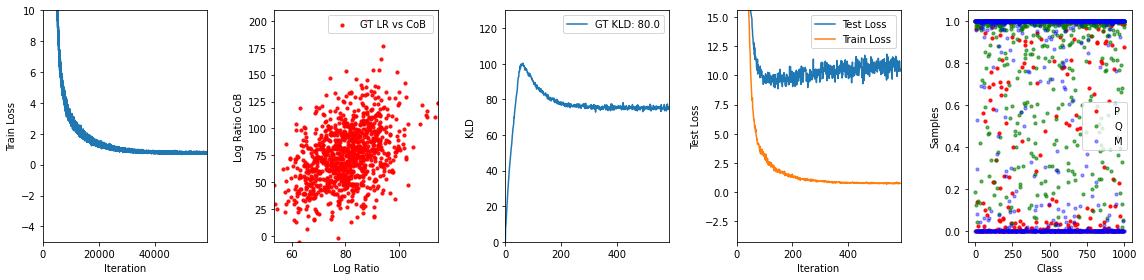

KeyboardInterrupt: 

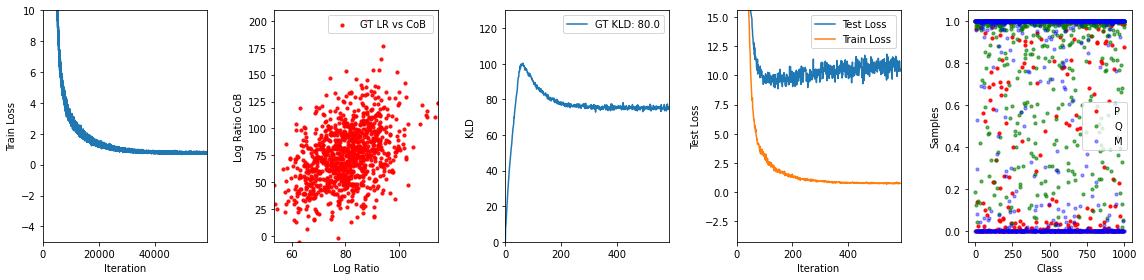

In [3]:
p_samples = tf.placeholder(tf.float32, shape=[None,n_dims])
q_samples = tf.placeholder(tf.float32, shape=[None,n_dims])
m_samples = tf.placeholder(tf.float32, shape=[None,n_dims])

dloss = get_loss(p_samples, q_samples, m_samples, None, deep=deep)
optim = get_optim(dloss,lr=5e-4)#,lr=5e-3,b1=.99

log_ratio_p_q, _ = get_gt_ratio_kl(p,q,p_samples)
_, kl_from_pq = get_gt_ratio_kl(p,q,p_samples)
kl_from_cob = get_kl_from_cob(p_samples, q_samples)

log_ratio_p_m = get_logits(p_samples,deep=deep, training=False)
logit_q = get_logits(q_samples,deep=deep, training=False)
logit_m = get_logits(m_samples,deep=deep, training=False)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
[kl_gt] = sess.run([p.kl_divergence(q)],feed_dict={})

fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(1, 5,figsize=(16,4))

line, = ax1.plot([0,1],[0,1])
test_line, = ax4.plot([0,1],[0,1],label='Test Loss')
test_line1, = ax4.plot([0,1],[0,1],label='Train Loss')
kld_line, = ax3.plot([0],[0],label='GT KLD: '+str(kl_gt))
x, y = np.random.random((2, 500))
np.random.randint
scat = ax2.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')

scat_p = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='P',alpha=0.9,s=10.,c='r')
scat_q = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='Q',alpha=0.6,s=10.,c='g')
scat_m = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='M',alpha=0.4,s=10.,c='b')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,N*(num_samples//bs)])
ax1.set_ylim([-5,10])

ax2.set_xlabel("Log Ratio")
ax2.set_ylabel("Log Ratio CoB")
ax2.legend(loc='best')

ax3.set_ylabel("KLD")
ax3.legend(loc='best')

ax4.set_xlabel("Iteration")
ax4.set_ylabel("Test Loss")
ax4.set_xlim([0,N//50])
ax4.set_ylim([-5,10])
ax4.legend(loc='best')

ax5.set_xlabel("Class")
ax5.set_ylabel("Samples")
ax5.legend(loc='best')


plt.tight_layout()
loss_store=[]
test_loss_store=[]
test_loss_store1=[]
kld_store=[]
pbar = range(0,N)
for j in pbar:
    for i in range(num_samples//bs):
        ps = p_list[np.random.choice(range(len(p_list)),bs)]
        qs = q_list[np.random.choice(range(len(q_list)),bs)]
        ms = m_list[np.random.choice(range(len(m_list)),bs)]
        feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
        
        l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
        loss_store.append(l)
        
        if i%100==0:
            line.set_data(range(len(loss_store)), loss_store)
            ax1.set_xlim( 0, len(loss_store) )
            
            ps = p_list_test[np.random.choice(range(len(p_list_test)),bs)]
            qs = q_list[np.random.choice(range(len(q_list)),bs)]
            ms = m_list_test[np.random.choice(range(len(m_list_test)),bs)]
            feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
            
            testl, lpq, lpqm, kl_cob, l_q, l_m = sess.run([dloss, log_ratio_p_q, log_ratio_p_m, kl_from_cob, logit_q, logit_m],feed_dict=feed_dict)
            kld_store.append(kl_cob)
            test_loss_store.append(testl)
            test_loss_store1.append(l)
#             cob = np.log([max(1e-10,n_[0]/n_[1]) for n_ in lpqm])
        
            cob=lpqm[:,0] - lpqm[:,1]
            scat.set_offsets(np.asarray([lpq,cob]).T)
            ax2.set_xlim( lpq.min(), lpq.max() )
#             ax2.set_ylim( lpq.min()-30, lpq.max()+10 )
            ax2.set_ylim( cob.min(), cob.max()+10 )

            kld_line.set_data(range(len(kld_store)),kld_store)
            ax3.set_xlim( 0, len(kld_store) )
            ax3.set_ylim( 0, kl_gt+50 )
#             ax3.set_ylim( 0, min(max(kld_store),500) )
            
            test_line1.set_data(range(len(test_loss_store1)), test_loss_store1)
            test_line.set_data(range(len(test_loss_store)), test_loss_store)
            ax4.set_xlim( 0, len(test_loss_store) )
            ax4.set_ylim([l.min()-5,testl.max()+5])
            
            
            
            scat_p.set_offsets(np.asarray([range(bs),softmax(lpqm,axis=1)[:,0]]).T)
            scat_q.set_offsets(np.asarray([range(bs),softmax(l_q, axis=1)[:,1]]).T)
            scat_m.set_offsets(np.asarray([range(bs),softmax(l_m, axis=1)[:,2]]).T)
            
             
            
            clear_output(wait=True)
            
            sp = (lpqm)
            sq = (l_q)
            sm = (l_m)
            print(sp)
            print(sq)
            print(sm)
            
            print(dloss.device)
            
            print(np.mean(np.exp(lpqm[:,0])))
            print(np.mean(np.exp(l_q[:,1])))
            print(np.mean(np.exp(l_m[:,2])))
            
#             if ( sp>0.99 and sq > 0.99 and sm>0.99 ):
#                 sys.exit(0)
                                                                                
            
            display(fig)
        


# sample_and_plot(sess, kld, kl_from_pq, kl_from_cob, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)



    

In [7]:
print(np.std(kld_store[-100:]),np.mean(kld_store[-100:]))

0.87039405 75.22787


In [ ]:
def kl(m1, s1, m2, s2):
    return np.log(s2)-np.log(s1)+(s1**2 + (m1-m2)**2)/(2*s2**2)-1/2

In [ ]:
plt.plot(test_loss_store1[:])
plt.plot(test_loss_store[:])

In [ ]:
(kld_store)